<a href="https://colab.research.google.com/github/nanopiero/fusion/blob/main/notebooks/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Plan d'expérience:

Régression

      - A.baseline radar cmls -> pluvios

Fusion, fusion multitâche

    - B.baseline radar + pluvio 1 min + cmls -> pluvios + cmls

    - C.tâches aux. 1.  A + tâche aux : -> val cml x masque segment x masque radar + val pluvio x masque pluvio x masque radar

    - D. tâches aux 2. tâche reconstruction PPI.
      - idée : f(radar[random_sample1], w) = y[70 x 64 x 64].  
         ft de coût : ||f(radar[random_sample1])[random_sample1_bar] - target ||
         + loss adversariale -> impossibilité de retrouver les indices renseignés

    - E. tâche aux 1 + tâche aux 2. A + (B) + c

Régression faiblement supervisée

    - E. introduction d'un bruit dans les CMLs et les pluvios

    - F. correction de l'effet du bruit dans les CMLs dans la loss (weak. sup.)

    - G. correction de l'effet du bruit par un réseau auxilaire (// denoising)





# Partie I : régression

In [1]:
! git clone https://github.com/nanopiero/fusion.git

Cloning into 'fusion'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 113 (delta 67), reused 4 (delta 0), pack-reused 0
Receiving objects: 100% (113/113), 1.31 MiB | 3.80 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [2]:
# Imports des bibliothèques utiles
# pour l'IA
import torch
# pour les maths
import numpy as np
# pour afficher des images et des courbes
import matplotlib.pyplot as plt

from random import randint
import os

# imports des fichiers locaux
os.chdir('fusion')
import utile_fusion
# import importlib
# importlib.reload(utile_fusion)

# Import des fonctions génératrices exploitées à l'échelle de l'image
from utile_fusion import spatialized_gt, create_cmls_filter
# Import des fonctions utilisées à l'échelle du batch, sur carte GPU
from utile_fusion import point_gt, segment_gt, make_noisy_images
#Import des fonctions de visualisation
from utile_fusion import set_tensor_values2, plot_images
from utile_fusion import FusionDataset


In [3]:
# config:
npoints = 10
npairs = 20
nsteps = 60
ndiscs = 5
size_image=64
length_dataset = 6400
device = torch.device('cuda:0')

In [20]:
# Dataset, DataLoader

dataset = FusionDataset(length_dataset=length_dataset,
                        npairs=npairs,
                        nsteps=nsteps,
                        ndiscs=ndiscs, size_image=size_image)

from torch.utils.data import DataLoader
loader = DataLoader(dataset, batch_size=64, num_workers=4)

In [21]:
# Essai avec un FCN (encodage simple)

################################   UNet (parties)###############################
import torch
import torch.nn as nn
import torch.nn.functional as F

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x



class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch, kernel_size=2, stride=2)

        self.conv = double_conv(2*in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)


    def forward(self, x):
        x = self.conv(x)
        return x


################################################################################
########################################   Mini Unet  ##########################

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes,size=64):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        self.up3 = Up(2*size, size)
        self.up4 = Up(size, size)
        self.outc = outconv(size, n_classes)
        self.outc2 = outconv(size, n_classes)
        self.n_classes=n_classes
        self.p = nn.Parameter(torch.ones(2))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return   x


# Exemple d'instanciation :
ch_in = 72
ch_out = nsteps * 3
size = nsteps * 3

model = UNet(ch_in, ch_out, size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)



In [22]:
def segment_gt(images, pairs, filters, use_fcn=False):
  bs, nsteps, S, _ = images.shape
  _, nlinks, _, _ = filters.shape

  filters[filters == 0] = torch.nan
  filtered_images = images.unsqueeze(dim=2) * \
                    filters.unsqueeze(dim=1)
  # on ajoute 0.1 pour distinguer du cas == 0
  sampled_values = torch.nanmean(filtered_images,\
                    dim=(3,4))
  segment_measurements = torch.cat((pairs, sampled_values), dim=1)
  filters[filters != filters] = 0

  if not use_fcn:
    return segment_measurements, None
  else:
    sampled_values += 0.1
    filters = filters.unsqueeze(1)
    filters = filters * sampled_values.view(bs, nsteps, nlinks, 1, 1)
    filters = filters.sum(dim=2)
  return segment_measurements, filters


def point_gt(images, npoints=10, use_fcn=False):
  bs, nsteps, S, _ = images.shape
  flat_images = images.view(bs, nsteps, S * S)
  # Randomly sample M indices for each image in the batch
  # indices = torch.randint(0, S * S, (bs, npoints), \
  #                         device=images.device)
  # pas de risque de superposition
  weights = torch.ones(S**2).expand(bs, -1).to(images.device)
  indices = torch.multinomial(weights, num_samples=npoints, replacement=False) #.to(images.device)

  # Calculate coordinates from indices
  rows = indices // S
  cols = indices % S

  # Gather the values from these indices for all images
  indices = indices.unsqueeze(dim=1).repeat([1,nsteps,1])
  sampled_values = torch.gather(flat_images, 2, indices)


  # Normalize coordinates to be between 0 and 1
  ys = (1 - rows.float()/S) - 1/(2*S)
  xs = cols.float()/S + 1/(2*S)
  # print(normalized_rows.shape)
  # print(sampled_values.shape)
  # Stack the normalized coordinates with the values
  point_measurements = torch.cat((xs.unsqueeze(1),
                      ys.unsqueeze(1),
                      sampled_values), dim=1)

  if not use_fcn:
    return point_measurements, None

  else:
    # Difference with point_gt:
    point_measurements_fcn = -0.1 * torch.ones(images.numel()).to(device)
    indices_batch = torch.arange(bs).repeat(60)
    # indice du premier élément de la i ème image pour le premier time step dans images.flatten()
    idx_i000=(torch.arange(bs, device = images.device) * nsteps).view(bs,1).expand(bs,nsteps)
    # indices du premier élément de la i ème image pour le premier time step j dans images.flatten()
    idx_ij00=idx_i000 + torch.arange(nsteps, device = images.device).view(1,nsteps).expand(bs,nsteps)
    # indices à conserver :
    idx_ijkl = S**2 * idx_ij00.unsqueeze(-1) + indices
    point_measurements_fcn[idx_ijkl.flatten()] = sampled_values.flatten()

    point_measurements_fcn = point_measurements_fcn.view(bs, nsteps, S, S)
  return point_measurements, point_measurements_fcn



"""
# Test code point_gt avec use_fcn
bs = 3
S = 5
npoints = 2
nsteps = 7

images = (torch.rand(bs, nsteps, S, S) > 0.5) + (torch.rand(bs, nsteps, S, S) > 0.5)
images = images.float().to('cuda:0')


bs, nsteps, S, _ = images.shape
flat_images = images.view(bs, nsteps, S * S)
# Randomly sample M indices for each image in the batch
indices = torch.randint(0, S * S, (bs, npoints), \
                        device=images.device)

weights = torch.ones(S**2).expand(bs, -1)
indices = torch.multinomial(weights, num_samples=npoints, replacement=False).to(images.device)
indices = indices.unsqueeze(dim=1).repeat([1,nsteps,1])

# Gather the values from these indices for all images
sampled_values = torch.gather(flat_images, 2, indices)
print(sampled_values.shape)


point_measurements = -0.1 * torch.ones(images.numel()).to(device)
indices_batch = torch.arange(bs).repeat(60)
# indice du premier élément de la i ème image pour le premier time step dans images.flatten()
idx_i000=(torch.arange(bs, device = images.device) * nsteps).view(bs,1).expand(bs,nsteps)
# indices du premier élément de la i ème image pour le premier time step j dans images.flatten()
idx_ij00=idx_i000 + torch.arange(nsteps, device = images.device).view(1,nsteps).expand(bs,nsteps)
# indices à conserver :
idx_ijkl = S**2 * idx_ij00.unsqueeze(-1) + indices
point_measurements[idx_ijkl.flatten()] = sampled_values.flatten()

point_measurements = point_measurements.view(bs, nsteps, S, S)
"""

def make_noisy_images(images):
    nbatch, nchannels, S, _ = images.shape

    # Step 1: Extract channels n°5 to 60, with a step of 5 (12 channels)
    extracted_images = images[:, torch.arange(4, 60, 5), :, :]  # Selects the 5th, 10th, ..., 60th channels

    # Step 2: Build a 25 x 25 Gaussian kernel with random std in [0,5]
    # and center taken in a random place around the square center (5 pixels max)
    kernel_size = 25
    central_square_size = 7
    std = torch.rand(nbatch, device=images.device) * 2.5

    center_x = (kernel_size - central_square_size) // 2 + torch.randint(0, central_square_size, (nbatch,), device=images.device)
    center_y = (kernel_size - central_square_size) // 2 + torch.randint(0, central_square_size, (nbatch,), device=images.device)

    x = torch.arange(kernel_size, dtype=torch.float32, \
                                  device=images.device)\
                                  .repeat(nbatch, kernel_size, 1)
    y = x.transpose(1, 2)

    center_x = center_x.view(-1, 1, 1)
    center_y = center_y.view(-1, 1, 1)
    std = std.view(-1, 1, 1)

    gaussian_kernel = torch.exp(-((x - center_x) ** 2 + (y - center_y) ** 2) / (2 * std ** 2))
    gaussian_kernel[gaussian_kernel < 0.1] = 0
    gaussian_kernel  /= gaussian_kernel.sum(dim=(1, 2), keepdim=True)
    gaussian_kernel  = gaussian_kernel.unsqueeze(1)

    # gaussian_kernel = gaussian_kernel.view(nbatch, 1, kernel_size, kernel_size)

    # Step 3: Apply the Gaussian kernel to all channels using conv2d
    transposed_images = extracted_images.permute(1, 0, 2, 3)  # (12, nbatch, S, S)
    noisy_images = F.conv2d(transposed_images, gaussian_kernel, padding='same', groups=nbatch)
    # print(noisy_images.shape)
    # Step 4: Binarize the output
    threshold =  0.4 * torch.rand(1,\
                       device=images.device) #torch.finfo(torch.float32).eps  # Tiny threshold
    binarized_images = (noisy_images > threshold).float()

    # Step 5: Re-transpose the dimensions back to (nbatch, nchannels, S, S)
    final_images = binarized_images.permute(1, 0, 2, 3)  # (nbatch, 12, S, S)

    return final_images


import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

class QPELoss_fcn(nn.Module):
    def __init__(self):
        super(QPELoss_fcn, self).__init__()
        self.regression_loss = nn.MSELoss()
        self.segmentation_loss = nn.CrossEntropyLoss()

    def forward(self, p, outputs, targets):

      # sans supervision imparfaite, avec spatialisation

      bs, nsteps, S, _ = targets.shape
      targets = targets.view(bs, 1, nsteps, S**2)
      mask = (targets>=0)
      masked_targets = targets[mask]
      outputs_rnr0 = outputs[:, :nsteps, ...].view(bs, 1, nsteps, S**2)
      outputs_rnr1 = outputs[:, nsteps:2*nsteps, ...].view(bs, 1, nsteps, S**2)
      masked_output_rnr = torch.cat([outputs_rnr0[mask].view(bs, 1, -1), outputs_rnr1[mask].view(bs, 1, -1)], dim=1)
      masked_target_rnr =  (masked_targets > 0).long().view(bs, -1)

      masked_output_qpe = outputs[:, 2*nsteps:3*nsteps , ...]\
                                .view(bs, 1, nsteps, S**2)[mask]\
                                 [masked_targets > 0]
      masked_target_qpe = masked_targets[masked_targets > 0]


      loss_rnr = self.segmentation_loss(masked_output_rnr, masked_target_rnr)



      loss_qpe_1min = self.regression_loss(masked_output_qpe, masked_target_qpe)

      loss = 1/(2*p[0]**2) * loss_qpe_1min + 1/(2*p[1]**2) * loss_rnr
      loss+= torch.log(1+p[0]**2+p[1]**2)

      with torch.no_grad():
        preds = masked_output_rnr.argmax(dim=1).flatten().cpu().numpy()
        targets = masked_target_rnr.flatten().cpu().numpy()
        # Compute the confusion matrix
        cm = confusion_matrix(targets, preds, labels=np.arange(2))
      # loss_qpe_5min =
      # loss_qpe_1h =
      # loss_fusion1 =

      # avec supervision imparfaite + spatialisation


      # avec supervision imparfaite + spatialisation + denoinsing

      # avec supervision imparfaite + spatialisation + denoising + GAN



      return loss_qpe_1min.item(), loss_rnr.detach().item(), loss, cm


def compute_metrics(confusion_matrix):
    tp = confusion_matrix[1, 1]
    tn = confusion_matrix[0, 0]
    fp = confusion_matrix[0, 1]
    fn = confusion_matrix[1, 0]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    csi = tp / (tp + fn + fp) if (tp + fn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    false_alarm_ratio = fp / (tp + fp) if (tp + fp) > 0 else 0

    return accuracy, csi, sensitivity, specificity, false_alarm_ratio



In [ ]:
criterion = QPELoss_fcn()

# Baseline with a FCN
use_fcn = True

best_loss = [float('inf'), float('inf')]  # Initialize best validation loss to a very high value
train_losses = []

In [46]:
for epoch in range(600):

  running_regression_loss = 0.0
  running_segmentation_loss = 0.0
  train_confusion_matrix = np.zeros((2, 2), dtype=int)
  for i, (images, pairs, filters) in enumerate(loader):

    # ground truth (not usable)
    images = images.clone().detach().float().to(device)

    # pseudo CMLs
    pairs = pairs.clone().detach().float().to(device)
    filters = filters.clone().float().detach().to(device)

    # for transformers :
    # segment_measurements = segment_gt(images, pairs, filters)
    segment_measurements, segment_measurements_fcn = segment_gt(images, pairs, filters, use_fcn=use_fcn)

    # pseudo pluvios
    point_measurements, point_measurements_fcn = point_gt(images, npoints=npoints, use_fcn=use_fcn)


    # pseudo radar
    noisy_images = make_noisy_images(images)

    # prepare inputs and targets
    inputs = torch.cat([noisy_images, segment_measurements_fcn], dim=1)
    targets = point_measurements_fcn


    optimizer.zero_grad()  # Zero the gradients
    outputs = model(inputs)  # Forward pass

    regression_loss, segmentation_loss, loss, batch_cm = criterion(model.p, outputs, targets)
    loss.backward()  # Backward pass
    optimizer.step()  # Update the weights

    del inputs, targets, outputs, loss, noisy_images, images, pairs, filters
    torch.cuda.empty_cache()

    running_regression_loss += regression_loss
    running_segmentation_loss += segmentation_loss
    train_confusion_matrix += batch_cm

  # Calculating average training loss
  train_regression_loss = running_regression_loss / len(loader)
  train_segmentation_loss = running_segmentation_loss / len(loader)
  train_losses.append((epoch, train_regression_loss, train_segmentation_loss, train_confusion_matrix))
  print(f'Training, Regression Loss: {train_regression_loss:.4f}, Segmentation Loss:{train_segmentation_loss:.4f}' )
  print("Train Confusion Matrix:")
  print(train_confusion_matrix)
  accuracy, csi, sensitivity, specificity, false_alarm_ratio = compute_metrics(train_confusion_matrix)
  print(f'Accuracy: {accuracy:.4f}, CSI: {csi:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, False Alarm Ratio: {false_alarm_ratio:.4f}')
  print('\n')


NameError: name 'aaa' is not defined

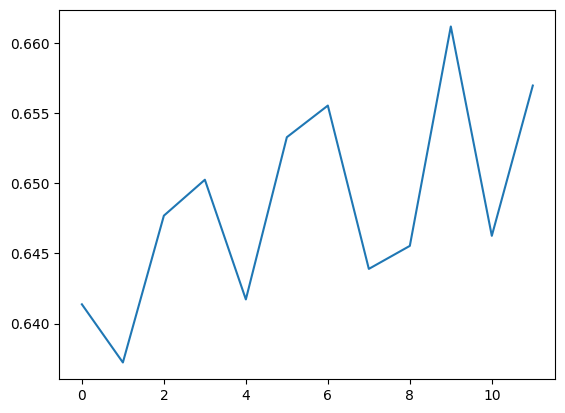

In [44]:
i = -1
j = 1
csi_values = [compute_metrics(x[i])[j] for x in train_losses]
# csi_values = [
#     0.6252, 0.6411, 0.6467, 0.6464, 0.6481, 0.6507, 0.6464, 0.6601, 0.6589, 0.6645,
#     0.6561, 0.6637, 0.6735, 0.6653, 0.6677, 0.6637, 0.6690, 0.6669, 0.6710, 0.6642,
#     0.6676, 0.6734, 0.6701, 0.6670, 0.6628, 0.6713, 0.6857, 0.6701, 0.6793, 0.6815,
#     0.6812, 0.6805, 0.6801, 0.6646, 0.6781, 0.6730, 0.6820, 0.6841, 0.6864, 0.6788,
#     0.6874, 0.6828, 0.6772, 0.6884, 0.6823, 0.6870, 0.6897, 0.6807, 0.6885, 0.6784,
#     0.6908, 0.6717, 0.6866, 0.6778, 0.6868, 0.6941, 0.6838, 0.6813, 0.6891, 0.6762,
#     0.6798, 0.6895, 0.6957, 0.6903, 0.6814, 0.6907, 0.6958, 0.6797, 0.6893, 0.6880,
#     0.6882, 0.6855, 0.6916, 0.6966, 0.6882, 0.6790, 0.6903, 0.6929, 0.6918, 0.6944,
#     0.6887, 0.7093, 0.6971, 0.7010, 0.7006, 0.7073, 0.6933
# ]

# regression_loss_values = [
#     0.0785, 0.0750, 0.0698, 0.0684, 0.0675, 0.0650, 0.0637, 0.0633, 0.0616, 0.0595,
#     0.0589, 0.0583, 0.0591, 0.0592, 0.0592, 0.0572, 0.0574, 0.0572, 0.0551, 0.0554,
#     0.0542, 0.0559, 0.0527, 0.0547, 0.0528, 0.0535, 0.0539, 0.0527, 0.0544, 0.0540,
#     0.0545, 0.0533, 0.0550, 0.0510, 0.0536, 0.0501, 0.0537, 0.0523, 0.0525, 0.0517,
#     0.0519, 0.0504, 0.0512, 0.0520, 0.0510, 0.0513, 0.0512, 0.0506, 0.0505, 0.0490,
#     0.0507, 0.0492, 0.0514, 0.0484, 0.0487, 0.0506, 0.0488, 0.0482, 0.0491, 0.0477,
#     0.0493, 0.0494, 0.0485, 0.0478, 0.0488, 0.0482, 0.0494, 0.0479, 0.0473, 0.0471,
#     0.0478, 0.0498, 0.0472, 0.0468, 0.0480, 0.0494, 0.0480, 0.0476, 0.0481, 0.0478,
#     0.0488, 0.0482, 0.0494, 0.0479, 0.0473, 0.0471, 0.0478, 0.0498, 0.0472, 0.0468,
#     0.0480
# ]

plt.plot(csi_values)

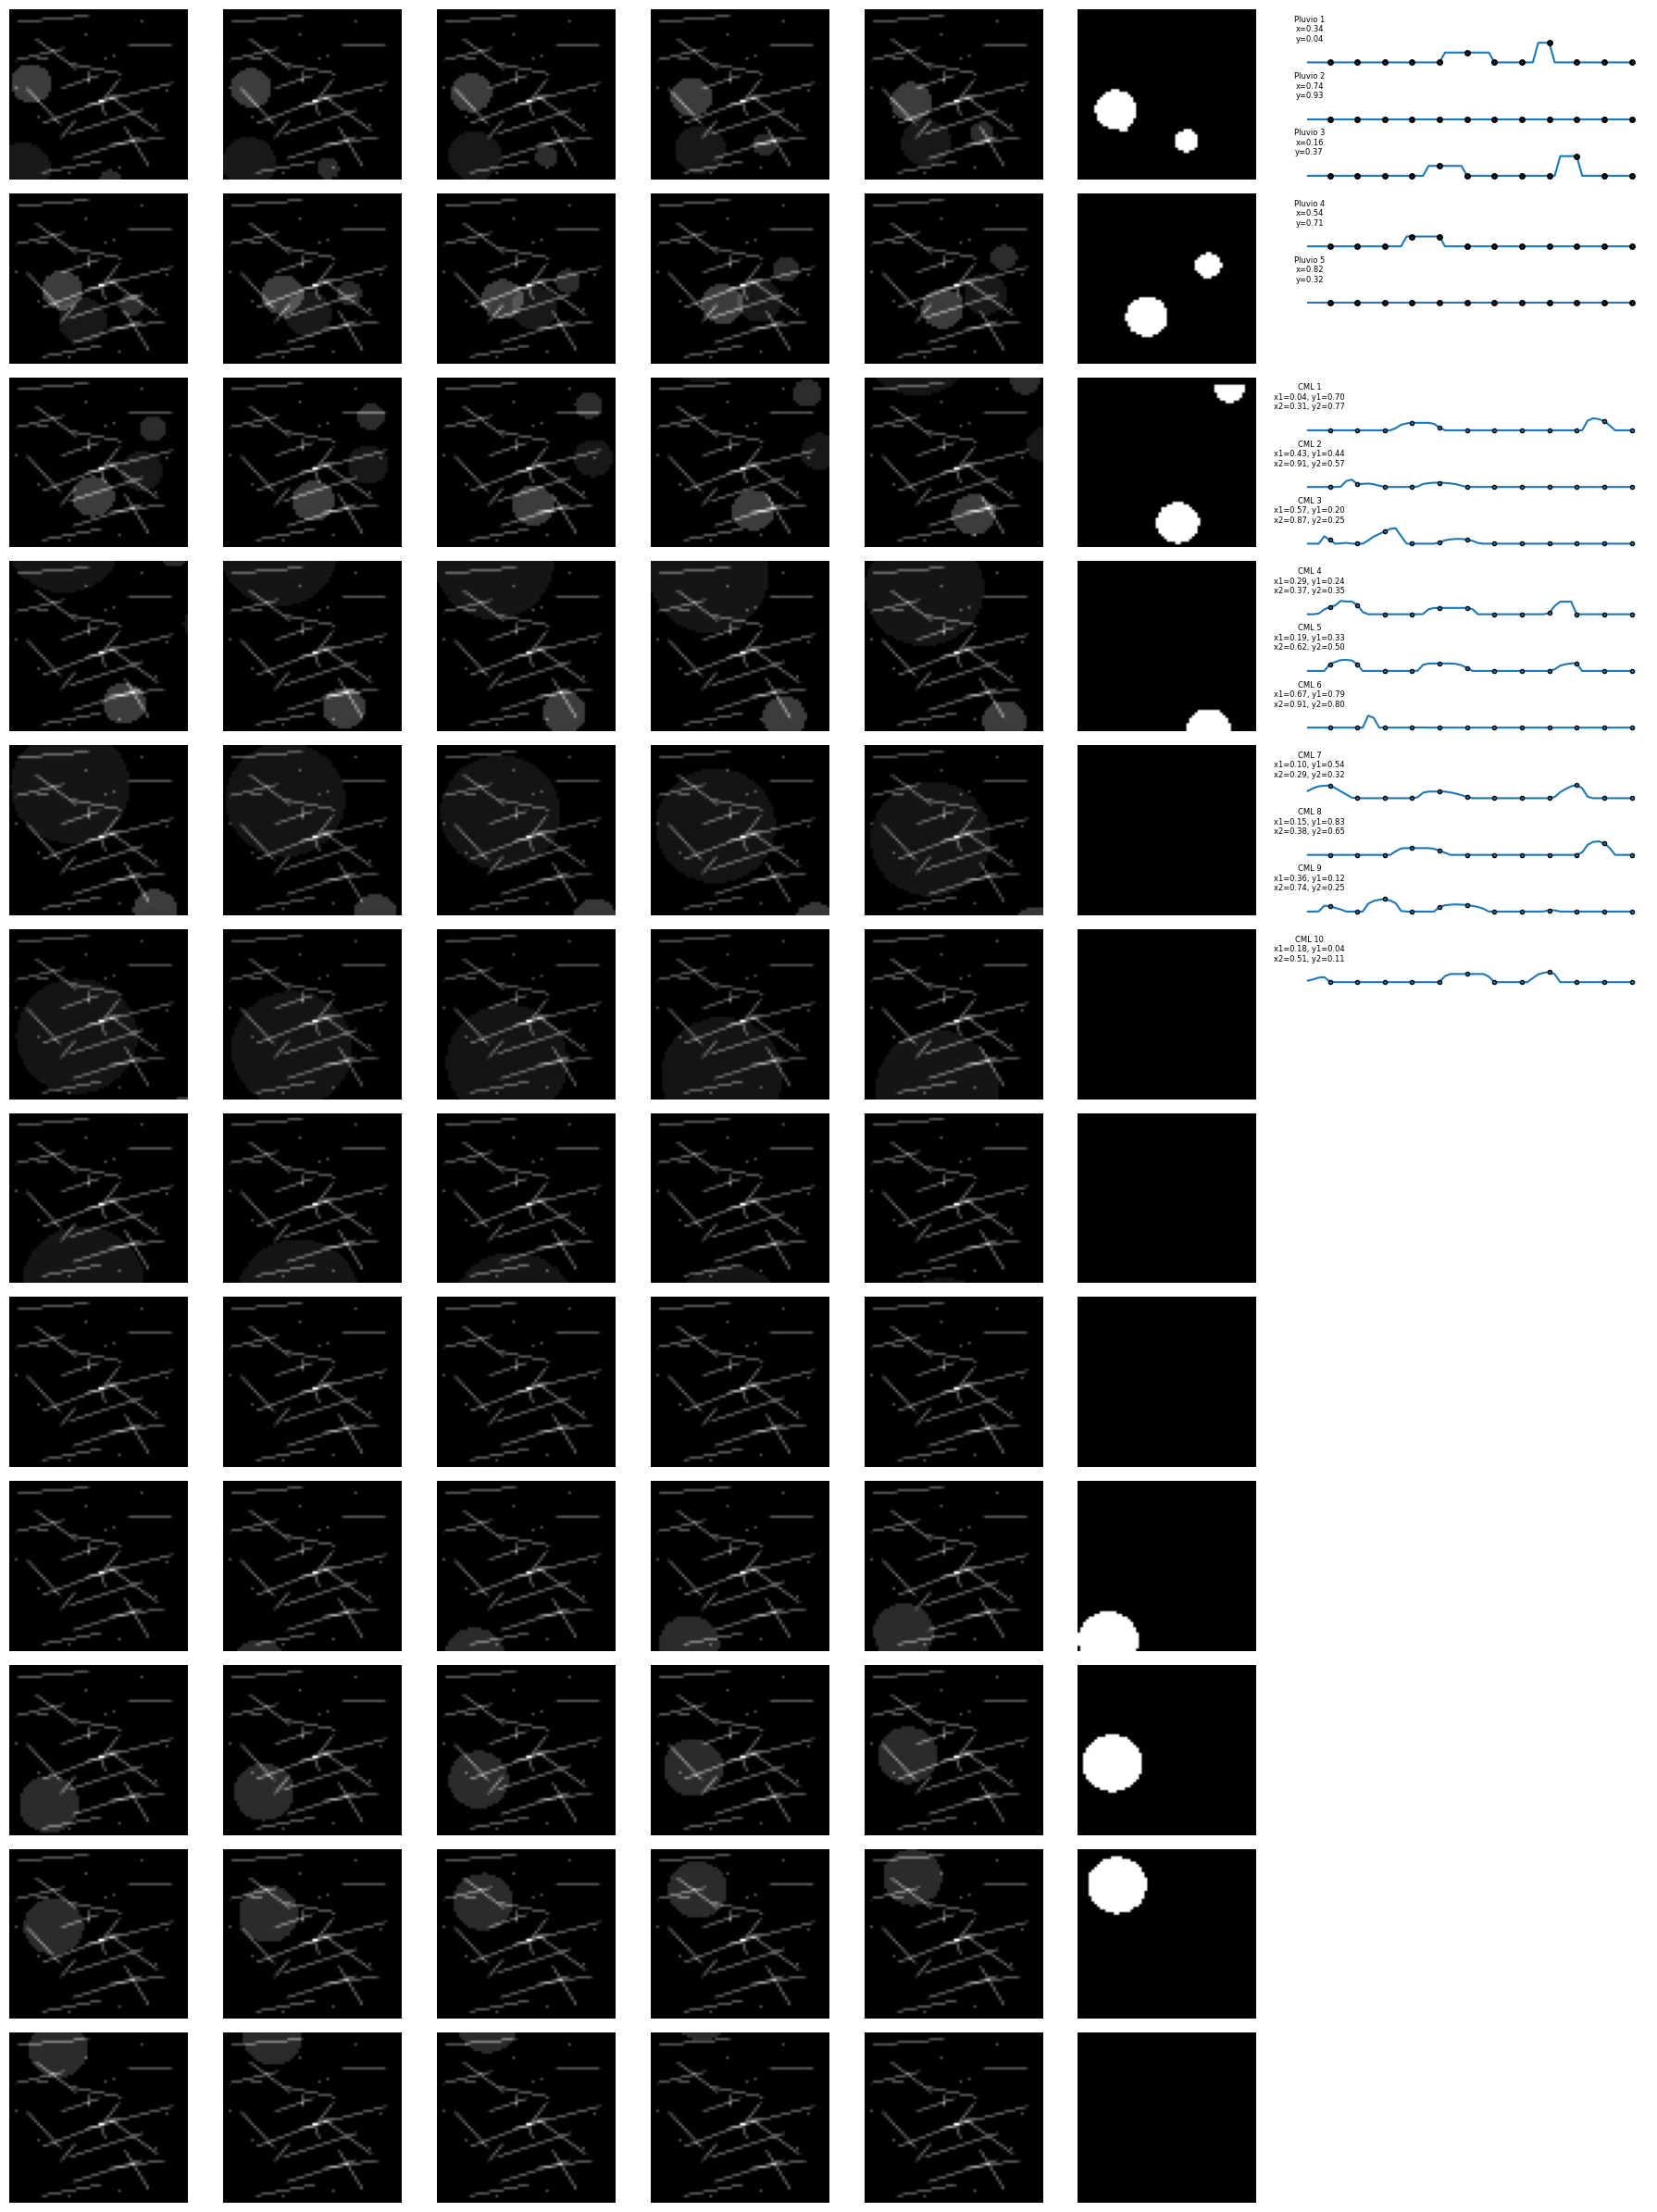

In [48]:
# Exemple / tracés

images = set_tensor_values2(images, point_measurements)
k=1
plot_images(images[k,...].cpu().numpy() + filters[k,...].cpu().numpy().sum(axis=0),
            noisy_images[k,...].cpu().numpy(),
            point_measurements[k,...].cpu().numpy(),
            segment_measurements[k,...].cpu().numpy())

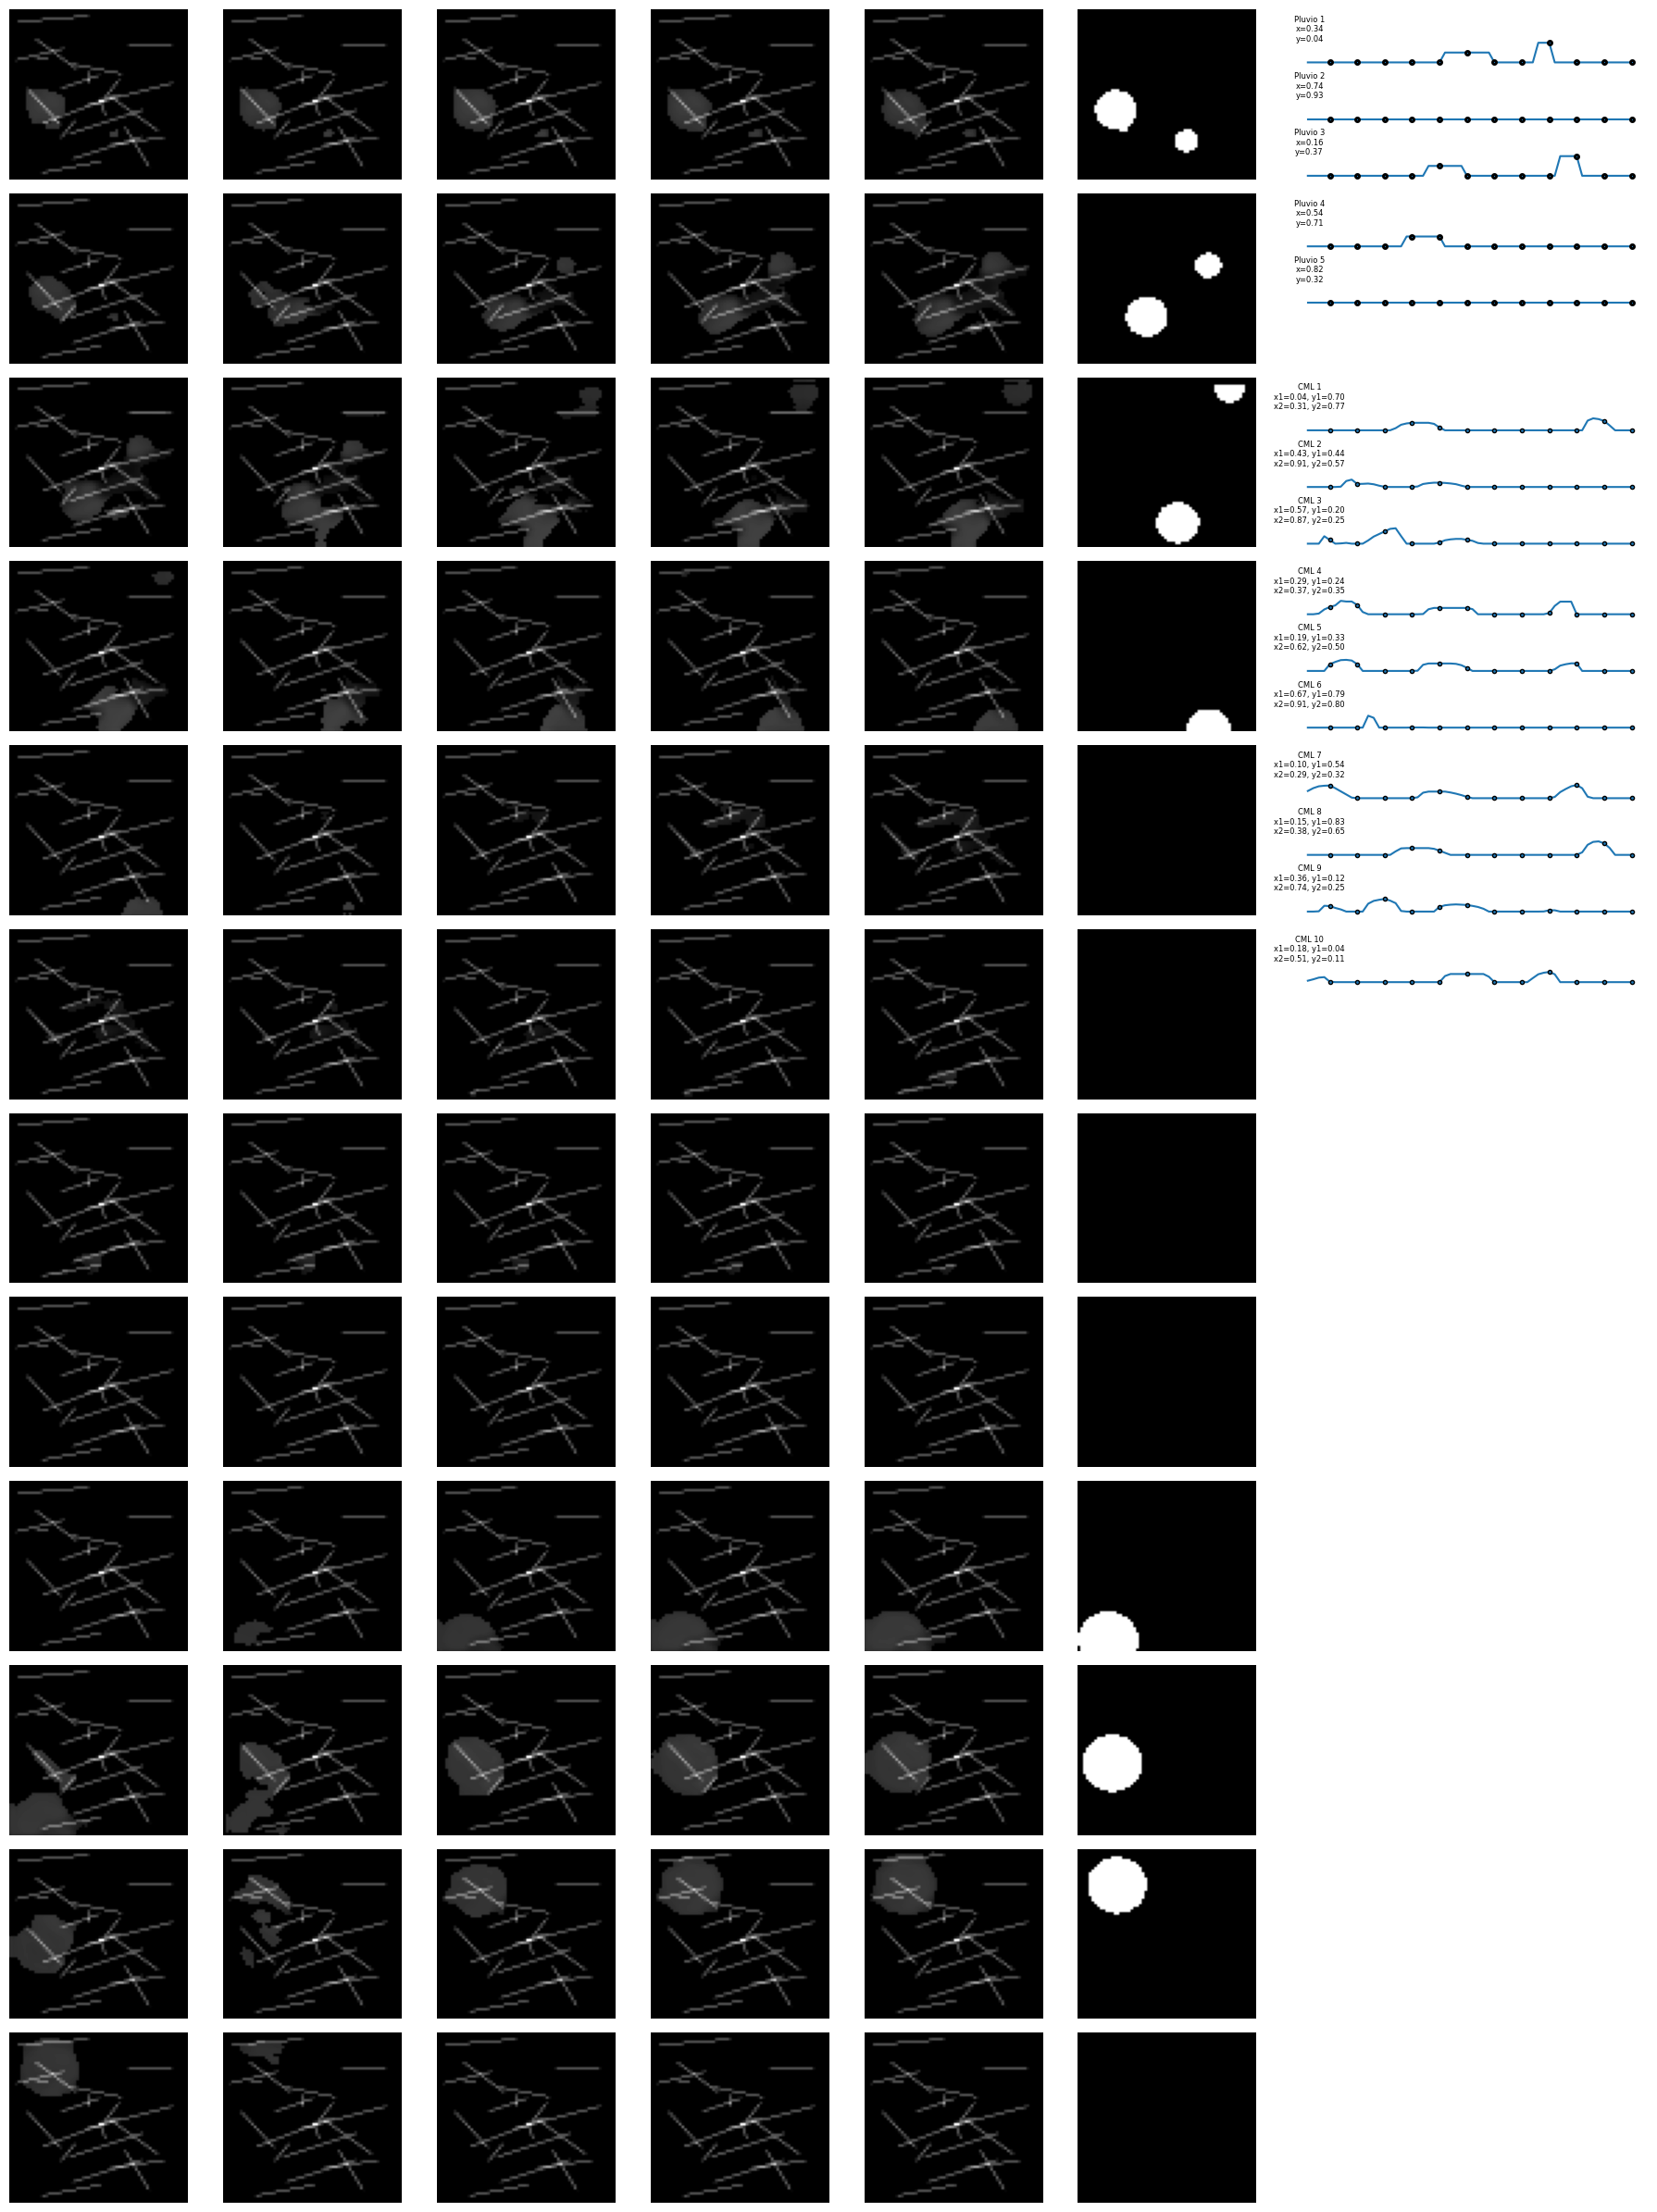

In [49]:
# Tracé output
model.eval()
inputs = torch.cat([noisy_images, segment_measurements_fcn], dim=1)
outputs = model(inputs)
mask_rnr = outputs[:, :nsteps,...] < outputs[:, nsteps:2*nsteps,...]
pred_images = (mask_rnr * outputs[:, 2*nsteps:3*nsteps, ...]).detach()
k=1
plot_images(pred_images[k,...].cpu().numpy() + filters[k,...].cpu().numpy().sum(axis=0),
            noisy_images[k,...].cpu().numpy(),
            point_measurements[k,...].cpu().numpy(),
            segment_measurements[k,...].cpu().numpy())

In [ ]:
# Archi

# cas d'un "fusion transformer 4d"
# Paramètres du modèle :
image_size = [64,64]
channels = 1
patch_size = 4
d_model = 120
mlp_expansion_ratio = 4
d_ff = mlp_expansion_ratio * d_model
n_heads = 4
n_layers = 12


model = FusionTransformer2dplus(image_size, patch_size, n_layers, d_model, d_ff, n_heads, channels=1)


In [ ]:
! pip install einops

#Transformer 2d, time = channels
from utile_Transformers import Block, Decoder
import torch.nn as nn

class UnifiedEmbedding2dplus(nn.Module):
  # le temps ici est compté comme un channel
    def __init__(self, d_model, patch_size, channels, nsteps):
        super().__init__()
        self.d_model = d_model
        self.patch_size = patch_size
        self.channels = channels
        self.nsteps = nsteps
        self.dim_modality = 4
        # Positional embedding for coordinates
        self.coord_embed = nn.Linear(2, d_model // 3)

        # Modality specific embeddings
        self.patch_modality = nn.Parameter(torch.randn(self.dim_modality))
        self.point_modality = nn.Parameter(torch.randn(self.dim_modality))
        self.segment_modality = nn.Parameter(torch.randn(self.dim_modality))

        # Feature embedding for radar image patches
        self.patch_feature_embed = nn.Conv2d(channels, d_model - self.dim_modality \
                - 2 * (d_model // 3), kernel_size=patch_size, stride=patch_size)

        # Feature embedding for point and segment rain rates
        self.punctual_rain_rate_embed = nn.Linear(nsteps, d_model - self.dim_modality \
                                                  - 2 * (d_model // 3))
        self.integrated_rain_rate_embed = nn.Linear(nsteps, d_model - self.dim_modality \
                                                   - 2 * (d_model // 3))

    def forward(self, image, points, segments):
        B, C, H, W = image.shape
        device = image.device
        # print("Image shape:", image.shape)

        # Embedding patches
        patch_embeddings = self.patch_feature_embed(image).flatten(2).transpose(1, 2)
        # print("Patch embeddings shape:", patch_embeddings.shape)

        # Create grid for patches
        grid_x, grid_y = torch.meshgrid(torch.arange(0, H, self.patch_size), torch.arange(0, W, self.patch_size), indexing='ij')
        grid_x = grid_x.to(device)
        grid_y = grid_y.to(device)
        upleft = torch.stack((grid_x.flatten(), grid_y.flatten()), dim=-1).float()
        downright = torch.stack((grid_x.flatten() + self.patch_size, grid_y.flatten() + self.patch_size), dim=-1).float()
        # erreur chatGPT !! patch_pos_embeddings = self.coord_embed(upleft) + self.coord_embed(downright)
        patch_pos_embeddings = torch.cat([self.coord_embed(upleft), self.coord_embed(downright)], dim=-1)
        patch_pos_embeddings = patch_pos_embeddings.repeat(B, 1, 1)
        # print("Patch positional embeddings shape:", patch_pos_embeddings.shape)

        patch_embeddings = torch.cat([patch_embeddings, patch_pos_embeddings, self.patch_modality.unsqueeze(0).expand(B, patch_embeddings.size(1), -1)], dim=-1)
        # print("Final patch embeddings shape:", patch_embeddings.shape)

        # Embedding points
        point_pos_embeddings = self.coord_embed(points[..., :2].float())
        # print("Point positional embeddings shape:", point_pos_embeddings.shape)

        point_feature_embeddings = self.punctual_rain_rate_embed(points[..., 2:].float())
        point_embeddings = torch.cat([point_feature_embeddings, point_pos_embeddings, point_pos_embeddings, self.point_modality.unsqueeze(0).expand(B, points.size(1), -1)], dim=-1)
        # print("Final point embeddings shape:", point_embeddings.shape)

        # Embedding segments
        seg_pos_embeddings0 = self.coord_embed(segments[..., :2].float())
        seg_pos_embeddings1 = self.coord_embed(segments[..., 2:4].float())
        segment_feature_embeddings = self.integrated_rain_rate_embed(segments[..., 4:].float())
        segment_embeddings = torch.cat([segment_feature_embeddings, seg_pos_embeddings0, seg_pos_embeddings1, self.segment_modality.unsqueeze(0).expand(B, segments.size(1), -1)], dim=-1)
        # print("Final segment embeddings shape:", segment_embeddings.shape)

        # Concatenate all embeddings
        embeddings = torch.cat([patch_embeddings, point_embeddings, segment_embeddings], dim=1)

        return embeddings

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)

def trunc_normal_(tensor, mean=0, std=1):
    nn.init.trunc_normal_(tensor, mean=mean, std=std)


class FusionTransformer2dplus(nn.Module):
    def __init__(
        self,
        image_size,
        patch_size,
        n_layers,
        d_model,
        d_ff,
        n_heads,
        channels=1,
        nsteps=60
    ):
        super().__init__()
        self.ue = UnifiedEmbedding2dplus(d_model, patch_size, channels, nsteps)
        self.patch_size = patch_size
        self.n_layers = n_layers
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads


        self.blocks = nn.ModuleList(
            [Block(d_model, n_heads, d_ff) for _ in range(n_layers)]
        )
        self.norm = nn.LayerNorm(d_model)

        self.apply(init_weights)

        self.decoder = Decoder(patch_size, d_model)

    def forward(self, x, y, z):
        # Embed signal
        x = self.ue(x, y, z)  # (B, N, D)

        # Process through each transformer block
        for block in self.blocks:
            x = block(x)

        # Apply final normalization
        x = self.norm(x)
        x = x[:,:256,:]

        x = self.decoder(x)

        return x


In [ ]:
model = model.to(device)

model(noisy_images, point_measurements, segment_measurements)

RuntimeError: Given groups=1, weight of size [36, 1, 4, 4], expected input[1, 12, 64, 64] to have 1 channels, but got 12 channels instead

In [ ]:
# Exemple / tracés
images = set_tensor_values2(images, point_measurements)
plot_images(images[0,...].cpu().numpy() + filters[0,...].cpu().numpy().sum(axis=0),
            noisy_images[0,...].cpu().numpy(),
            point_measurements[0,...].cpu().numpy(),
            segment_measurements[0,...].cpu().numpy())

tensor(0.1194, device='cuda:0')